In this article, I will step through the process of forecasting the number of bicycles traveling on the Custis trail daily by using sophisticated machine learning techniques.  Originally, I was planning on using data from the Bikeometer in Rosslyn, but it has been offline since March 25th. <!-- TEASER_END --> Thankfully, there are several other counters on this trail as you can see from my earlier article [mapping Arlington’s bike and pedestrian counters](https://georgetsilva.github.io/posts/mapping-points-with-folium/).

The longest running and probably most reliable trail counter in Arlington is the Custis Rosslyn EcoMulti installed in October of 2009. It is located on the Custis trail near where westbound lane of Lee Highway crosses over I-66. Given its long time series of data and reliability, it is probably the best source of data from this project.

My first step in this project was to launch Anaconda and start this Python 3.5 Jupyter Notebook. Then I import the modules I plan to use for this project. They are as follows:

In [1]:
import pandas as pd
import requests
from xml.etree import ElementTree
import numpy as np

Using the requests module to retrieve data from Bike Arlington Web Services, I pulled all the daily counter data for bicycles crossing the Custis Rosslyn counter (counterid=4) for the October 1, 2009 to May 15, 2017 time period.


In [2]:
url = "http://webservices.commuterpage.com/counters.cfc?wsdl&method=GetCountInDateRange&counterid=4&startDate=10/01/2009&endDate=05/15/2017&direction=&mode=B&interval=d"
xmlfile = open('xml_bikeometer.xml', 'w')
xmldata = requests.get(url)
xmlfile.write(xmldata.text)
xmlfile.close()

xml_data = 'xml_bikeometer.xml'

The code below parses the xml data and stores it in a Pandas dataframe, which is kind of like an Excel table.

In [3]:
document = ElementTree.parse(xml_data)
date = []
count = []
direction = []
for day in document.findall('count'):
    date.append(day.attrib['date'])
    count.append(day.attrib['count'])
    direction.append(day.attrib['direction'])
dfbikes = pd.DataFrame({'date' : date, 'count': count, 'direction': direction}, dtype = int)
dfbikes['date'] = pd.to_datetime(dfbikes.date)
dfbikes = dfbikes.groupby('date').sum()
dfbikes.tail()

,count
date,
2017-05-11,513
2017-05-12,706
2017-05-13,434
2017-05-14,1522
2017-05-15,1978


Then I loaded in weather data that I downloaded from the NOAA National Centers for Environmental Information.  This U.S. Local Climatological Data for the National Airport weather station ended up being somewhat problematic.  The data structure was a bit difficult to work with and had large blocks of missing data for some weather measurements, such as relative humidity.  Given these issues, I decided to only extract the snow data and instead get the rest of the historical weather data from Weather Underground.

In [5]:
weather = pd.read_csv('weather09t17.csv', usecols=['REPORTTPYE','DATE', 'DAILYMaximumDryBulbTemp','DAILYAverageRelativeHumidity',
                                        'DAILYAverageWindSpeed', 'DAILYPrecip', 'DAILYSnowfall', 'DAILYSnowDepth'])

daily_weather = weather.loc[weather['REPORTTPYE'] == 'SOD', :]
daily_weather['date'] = pd.to_datetime(daily_weather.DATE, format='%Y-%m-%d').dt.date
daily_weather = daily_weather.set_index('date')
snow_weather = daily_weather[['DAILYSnowfall', 'DAILYSnowDepth']]
snow_weather.tail()

C:\Users\George\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (40) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
C:\Users\George\Anaconda3\lib\site-packages\ipykernel\__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,DAILYSnowfall,DAILYSnowDepth
date,,
2017-05-09,0.0,0
2017-05-10,0.0,0
2017-05-11,0.0,0
2017-05-12,0.0,0
2017-05-13,0.0,0


In [6]:
swcolumns = snow_weather.columns
swindex = pd.date_range('2017-05-14', periods = 2).date
sw_append = pd.DataFrame([[0.0, 0], [0.0, 0]], columns=swcolumns, index=swindex)
snow_weather = snow_weather.append(sw_append)
snow_weather.tail()

,DAILYSnowfall,DAILYSnowDepth
2017-05-11,0.0,0
2017-05-12,0.0,0
2017-05-13,0.0,0
2017-05-14,0,0
2017-05-15,0,0


The weather_kdca0917.csv file contains the 2009 to May 15, 2017 Arlington, Virginia historical weather data from Weather Underground. The available weather fields are listed below.

In [7]:
df_wu = pd.read_csv('weather_kdca0917.csv', index_col='date', parse_dates=True)
df_wu.dtypes

CloudCover                     int64
Max Dew PointF                 int64
Max Gust SpeedMPH            float64
Max Humidity                   int64
Max Sea Level PressureIn     float64
Max TemperatureF               int64
Max VisibilityMiles            int64
Max Wind SpeedMPH              int64
Mean Humidity                  int64
Mean Sea Level PressureIn    float64
Mean TemperatureF              int64
Mean VisibilityMiles           int64
Mean Wind SpeedMPH             int64
MeanDew PointF                 int64
Min DewpointF                  int64
Min Humidity                   int64
Min Sea Level PressureIn     float64
Min TemperatureF               int64
Min VisibilityMiles            int64
PrecipitationIn              float64
WindDirDegrees                 int64
Snow                           int64
Fog                            int64
dtype: object

The dfsunrise data is sunrise and sunset times for Arlington, Virginia.  It obtained from the [U.S. Naval Observatory](http://www.usno.navy.mil/USNO/).


In [8]:
dfsunrise = pd.read_pickle('sunrise120120102017.pkl')

I then concatenated the four previous tables by date.

In [9]:
bikedataframe = pd.concat([dfbikes, snow_weather, df_wu, dfsunrise], axis=1)

#bikedataframe = bikedataframe.drop(['DATE', 'REPORTTPYE'], axis=1)
bikedataframe.head()

,count,DAILYSnowfall,DAILYSnowDepth,CloudCover,Max Dew PointF,Max Gust SpeedMPH,Max Humidity,Max Sea Level PressureIn,Max TemperatureF,Max VisibilityMiles,...,WindDirDegrees,Snow,Fog,month,day,year,sunrise,sunset,sunrise_int,sunset_int
2009-01-01,NaN,NaN,NaN,2.0,14.0,31.0,53.0,30.42,34.0,10.0,...,284.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-01-02,NaN,NaN,NaN,6.0,29.0,24.0,70.0,30.18,43.0,10.0,...,198.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-01-03,NaN,NaN,NaN,1.0,29.0,21.0,75.0,30.20,47.0,10.0,...,349.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-01-04,NaN,NaN,NaN,6.0,31.0,12.0,78.0,30.22,45.0,10.0,...,182.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-01-05,NaN,NaN,NaN,8.0,37.0,22.0,92.0,30.08,51.0,10.0,...,341.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Then I converted the data to floating point numbers in preparation for the machine learning modeling. I also calculated weekday versus weekends, converted the sunset and sunrise times to fractional hours, and then calculated the number of hours of daylight time. The year variable was also adjusted to be the number of years since 2000 for scaling purposes.

In [10]:
bikedataframe = bikedataframe.drop(['sunrise', 'sunset'], 1)
bikedataframe = bikedataframe.replace(to_replace='T', value=0.01)
bikedataframe = bikedataframe.astype(float)
bikedataframe["dayofweek"] = bikedataframe.index.dayofweek
bikedataframe["weekday"] = 0
bikedataframe['weekday'] = np.where(bikedataframe['dayofweek'] < 5, 1, 0)
bikedataframe['sunsethour'] = (bikedataframe['sunset_int'] // 100) + ((bikedataframe['sunset_int'] % 100) / 60)
bikedataframe['sunrisehour'] = (bikedataframe['sunrise_int'] // 100) + ((bikedataframe['sunrise_int'] % 100) / 60)
bikedataframe['day_hrs'] = bikedataframe['sunsethour'] - bikedataframe['sunrisehour']
bikedataframe['year'] = bikedataframe['year'] - 2000
bikedataframe.tail(10)

,count,DAILYSnowfall,DAILYSnowDepth,CloudCover,Max Dew PointF,Max Gust SpeedMPH,Max Humidity,Max Sea Level PressureIn,Max TemperatureF,Max VisibilityMiles,...,month,day,year,sunrise_int,sunset_int,dayofweek,weekday,sunsethour,sunrisehour,day_hrs
2017-12-22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,12.0,22.0,17.0,724.0,1651.0,4,1,16.850000,7.400000,9.450000
2017-12-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,12.0,23.0,17.0,724.0,1651.0,5,0,16.850000,7.400000,9.450000
2017-12-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,12.0,24.0,17.0,725.0,1652.0,6,0,16.866667,7.416667,9.450000
2017-12-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,12.0,25.0,17.0,725.0,1652.0,0,1,16.866667,7.416667,9.450000
2017-12-26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,12.0,26.0,17.0,726.0,1653.0,1,1,16.883333,7.433333,9.450000
2017-12-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,12.0,27.0,17.0,726.0,1654.0,2,1,16.900000,7.433333,9.466667
2017-12-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,12.0,28.0,17.0,726.0,1654.0,3,1,16.900000,7.433333,9.466667
2017-12-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,12.0,29.0,17.0,726.0,1655.0,4,1,16.916667,7.433333,9.483333
2017-12-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,12.0,30.0,17.0,727.0,1656.0,5,0,16.933333,7.450000,9.483333
2017-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,12.0,31.0,17.0,727.0,1657.0,6,0,16.950000,7.450000,9.500000


Holidays can also influence bike usage, especially commuter patterns. I used a built in Pandas function to get all the Federal holidays for 2009 to 2017.


In [12]:
from pandas.tseries.holiday import USFederalHolidayCalendar
cal = USFederalHolidayCalendar()
holidays = cal.holidays('2009', '2018')
bikedataframe = bikedataframe.join(pd.Series(1, index=holidays, name='holiday'))
bikedataframe['holiday'].fillna(0, inplace=True)

In [13]:
holidays

DatetimeIndex(['2009-01-01', '2009-01-19', '2009-02-16', '2009-05-25',
               '2009-07-03', '2009-09-07', '2009-10-12', '2009-11-11',
               '2009-11-26', '2009-12-25', '2010-01-01', '2010-01-18',
               '2010-02-15', '2010-05-31', '2010-07-05', '2010-09-06',
               '2010-10-11', '2010-11-11', '2010-11-25', '2010-12-24',
               '2010-12-31', '2011-01-17', '2011-02-21', '2011-05-30',
               '2011-07-04', '2011-09-05', '2011-10-10', '2011-11-11',
               '2011-11-24', '2011-12-26', '2012-01-02', '2012-01-16',
               '2012-02-20', '2012-05-28', '2012-07-04', '2012-09-03',
               '2012-10-08', '2012-11-12', '2012-11-22', '2012-12-25',
               '2013-01-01', '2013-01-21', '2013-02-18', '2013-05-27',
               '2013-07-04', '2013-09-02', '2013-10-14', '2013-11-11',
               '2013-11-28', '2013-12-25', '2014-01-01', '2014-01-20',
               '2014-02-17', '2014-05-26', '2014-07-04', '2014-09-01',
      

I also noticed that Bike to Work Day also impacts bike counts, so I added in those dates as bike_events. Are there any other bike events that should be added to these?

In [14]:
bike_events = pd.DatetimeIndex(['2010-05-21', '2011-05-20', '2012-05-18', '2013-05-17', '2014-05-16', '2015-05-15', '2016-05-20', '2017-05-19'])
bike_events

DatetimeIndex(['2010-05-21', '2011-05-20', '2012-05-18', '2013-05-17',
               '2014-05-16', '2015-05-15', '2016-05-20', '2017-05-19'],
              dtype='datetime64[ns]', freq=None)

In [15]:
bikedataframe = bikedataframe.join(pd.Series(1, index=bike_events, name='bike_events'))
bikedataframe['bike_events'].fillna(0, inplace=True)

I then did a bit of data cleaning.  First, I dropped all rows with any missing data.

In [17]:
bikedataframe.dropna(axis=0, how='any', thresh=None, subset=None, inplace=True)

Then I dropped any rows with counter data that did not have positive bike counts. This eliminated days when the counter might not have been working. (After making the bike counter model, we could go back and predict the bike counts for those days when the counter might not have been working correctly.)

In [20]:
bikedataframe = bikedataframe.loc[bikedataframe['count'] > 0]
bikedataframe.shape

(2605, 38)

In [21]:
bikedataframe.dtypes

count                        float64
DAILYSnowfall                float64
DAILYSnowDepth               float64
CloudCover                   float64
Max Dew PointF               float64
Max Gust SpeedMPH            float64
Max Humidity                 float64
Max Sea Level PressureIn     float64
Max TemperatureF             float64
Max VisibilityMiles          float64
Max Wind SpeedMPH            float64
Mean Humidity                float64
Mean Sea Level PressureIn    float64
Mean TemperatureF            float64
Mean VisibilityMiles         float64
Mean Wind SpeedMPH           float64
MeanDew PointF               float64
Min DewpointF                float64
Min Humidity                 float64
Min Sea Level PressureIn     float64
Min TemperatureF             float64
Min VisibilityMiles          float64
PrecipitationIn              float64
WindDirDegrees               float64
Snow                         float64
Fog                          float64
month                        float64
d

In [ ]:
I decided to merge the snow data into one snowtotal field that merges snowfall and snow depth measurements.

In [22]:
bikedataframe['snowtotal'] = np.where(bikedataframe['DAILYSnowfall'] > bikedataframe['DAILYSnowDepth'],
                                      bikedataframe['DAILYSnowfall'], bikedataframe['DAILYSnowDepth'])



After some playing around, I decided to include the following fields in the daily bike counter model:
* Max TemperatureF
* Min TemperatureF
* Max Humidity
* Max Wind SpeedMPH
* PrecipitationIn
* weekday
* holiday
* day_hrs
* snowtotal
* Fog
* year
* sunsethour
* CloudCover
* bike_events


In [ ]:
names = ['Max TemperatureF', 'Min TemperatureF', 'Max Humidity', 'Max Wind SpeedMPH', 'PrecipitationIn', 'weekday', 'holiday', 'day_hrs',
         'snowtotal', 'Fog', 'year', 'sunsethour', 'CloudCover', 'bike_events']


Next I set the model X and Y variables.

In [23]:
X = bikedataframe[names]
X.shape

(2605, 14)

In [24]:
y = bikedataframe['count']

Now that the data is all cleaned up and selected, it is ready for modeling. However, I wasn’t sure which model to use and how to specify it. This process could have taken me days of research and I did try traditional linear regression and a few slightly more advanced methods before I decided to let the machine do the work. I found a python module called [TPOT](https://github.com/rhiever/tpot) that automatically creates and optimizes machine learning pipelines using genetic programming.


In [25]:
from tpot import TPOTRegressor
from sklearn.model_selection import train_test_split

I set aside 25 percent of the data as a testing dataset and trained the model with the remaining 75 percent of the data. This helps avoid overfitting issues and allows us to test the model on data that was not used to create the model.

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    train_size=0.75, test_size=0.25, random_state=1)


After to TPOT runs for an hour or two on the training dataset, it produces the recommended machine learning code that works best for this dataset.

In [28]:
tpot = TPOTRegressor(verbosity=2)
tpot.fit(X_train, y_train)
print(tpot.score(X_test, y_test))
tpot.export('bikeometer_pipeline_custis4boost.py')

Version 0.7.0 of tpot is outdated. Version 0.7.3 was released Friday April 28, 2017.


Generation 1 - Current best internal CV score: 46963.75152176955


Generation 2 - Current best internal CV score: 46215.097061178894


Generation 3 - Current best internal CV score: 46215.097061178894


Generation 4 - Current best internal CV score: 46215.097061178894


Generation 5 - Current best internal CV score: 46215.097061178894


Generation 6 - Current best internal CV score: 45811.474585961834


Generation 7 - Current best internal CV score: 45811.474585961834


Generation 8 - Current best internal CV score: 45741.32268883569


Generation 9 - Current best internal CV score: 45471.58471266144


Generation 10 - Current best internal CV score: 45437.128870773384


Generation 11 - Current best internal CV score: 45437.128870773384


Generation 12 - Current best internal CV score: 45287.84576732571


Generation 13 - Current best internal CV score: 44118.3220847647


Generation 14 - Current best internal CV score: 44118.3220847647


Generation 15 - Current best internal CV score: 44118.3220847647


Generation 16 - Current best internal CV score: 44018.02264580266


Generation 17 - Current best internal CV score: 44018.02264580266


Generation 18 - Current best internal CV score: 43699.12365336018


Generation 19 - Current best internal CV score: 43570.83523814218


Generation 20 - Current best internal CV score: 43570.83523814218


Generation 21 - Current best internal CV score: 43570.83523814218


Generation 22 - Current best internal CV score: 43412.08478799059


Generation 23 - Current best internal CV score: 43334.0359518531


Generation 24 - Current best internal CV score: 43334.0359518531


Generation 25 - Current best internal CV score: 42719.91053998506


Generation 26 - Current best internal CV score: 42719.91053998506


Generation 27 - Current best internal CV score: 42719.91053998506


Generation 28 - Current best internal CV score: 42719.91053998506


Generation 29 - Current best internal CV score: 42719.91053998506


Generation 30 - Current best internal CV score: 42719.91053998506


Generation 31 - Current best internal CV score: 42719.91053998506


Generation 32 - Current best internal CV score: 42719.91053998506


Generation 33 - Current best internal CV score: 42719.91053998506


Generation 34 - Current best internal CV score: 42719.91053998506


Generation 35 - Current best internal CV score: 42719.91053998506


Generation 36 - Current best internal CV score: 42719.91053998506


Generation 37 - Current best internal CV score: 42719.91053998506


Generation 38 - Current best internal CV score: 42719.91053998506


Generation 39 - Current best internal CV score: 42719.91053998506


Generation 40 - Current best internal CV score: 42719.91053998506


Generation 41 - Current best internal CV score: 42719.91053998506


Generation 42 - Current best internal CV score: 42719.91053998506


Generation 43 - Current best internal CV score: 42719.91053998506


Generation 44 - Current best internal CV score: 42671.90919197114


Generation 45 - Current best internal CV score: 42671.90919197114


Generation 46 - Current best internal CV score: 42671.90919197114


Generation 47 - Current best internal CV score: 42671.90919197114


Generation 48 - Current best internal CV score: 42671.90919197114


Generation 49 - Current best internal CV score: 42671.90919197114


Generation 50 - Current best internal CV score: 42671.90919197114


Generation 51 - Current best internal CV score: 42671.90919197114


Generation 52 - Current best internal CV score: 42671.90919197114


Generation 53 - Current best internal CV score: 42671.90919197114


Generation 54 - Current best internal CV score: 42671.90919197114


Generation 55 - Current best internal CV score: 42671.90919197114


Generation 56 - Current best internal CV score: 42671.90919197114


Generation 57 - Current best internal CV score: 42671.90919197114


Generation 58 - Current best internal CV score: 42671.90919197114


Generation 59 - Current best internal CV score: 42671.90919197114


Generation 60 - Current best internal CV score: 42671.90919197114


Generation 61 - Current best internal CV score: 42671.90919197114


Generation 62 - Current best internal CV score: 42671.90919197114


Generation 63 - Current best internal CV score: 42671.90919197114


Generation 64 - Current best internal CV score: 42671.90919197114


Generation 65 - Current best internal CV score: 42671.90919197114


Generation 66 - Current best internal CV score: 42671.90919197114


Generation 67 - Current best internal CV score: 42671.90919197114


Generation 68 - Current best internal CV score: 42671.90919197114


Generation 69 - Current best internal CV score: 42671.90919197114


Generation 70 - Current best internal CV score: 42671.90919197114


Generation 71 - Current best internal CV score: 42671.90919197114


Generation 72 - Current best internal CV score: 42671.90919197114


Generation 73 - Current best internal CV score: 42671.90919197114


Generation 74 - Current best internal CV score: 42671.90919197114


Generation 75 - Current best internal CV score: 42671.90919197114


Generation 76 - Current best internal CV score: 42671.90919197114


Generation 77 - Current best internal CV score: 42671.90919197114


Generation 78 - Current best internal CV score: 42671.90919197114


Generation 79 - Current best internal CV score: 42671.90919197114


Generation 80 - Current best internal CV score: 42671.90919197114


Generation 81 - Current best internal CV score: 42671.90919197114


Generation 82 - Current best internal CV score: 42671.90919197114


Generation 83 - Current best internal CV score: 42671.90919197114


Generation 84 - Current best internal CV score: 42671.90919197114


Generation 85 - Current best internal CV score: 42671.90919197114


Generation 86 - Current best internal CV score: 42671.90919197114


Generation 87 - Current best internal CV score: 42671.90919197114


Generation 88 - Current best internal CV score: 42671.90919197114


Generation 89 - Current best internal CV score: 42671.90919197114


Generation 90 - Current best internal CV score: 42671.90919197114


Generation 91 - Current best internal CV score: 42671.90919197114


Generation 92 - Current best internal CV score: 42671.90919197114


Generation 93 - Current best internal CV score: 42671.90919197114


Generation 94 - Current best internal CV score: 42671.90919197114


Generation 95 - Current best internal CV score: 42671.90919197114


Generation 96 - Current best internal CV score: 42671.90919197114


Generation 97 - Current best internal CV score: 42671.90919197114


Generation 98 - Current best internal CV score: 42671.90919197114


Generation 99 - Current best internal CV score: 42671.90919197114


Generation 100 - Current best internal CV score: 42671.90919197114



Best pipeline: GradientBoostingRegressor(RobustScaler(input_matrix), GradientBoostingRegressor__alpha=0.8, GradientBoostingRegressor__learning_rate=DEFAULT, GradientBoostingRegressor__loss=huber, GradientBoostingRegressor__max_depth=5, GradientBoostingRegressor__max_features=0.45, GradientBoostingRegressor__min_samples_leaf=1, GradientBoostingRegressor__min_samples_split=20, GradientBoostingRegressor__subsample=DEFAULT)
51126.5686691


TPOT recommended a machine learning pipeline that uses RobustScaler that standardizes the dataset to be robust to outliers. Then a model is created using Gradient Boosting for regression.

In [29]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler

exported_pipeline = make_pipeline(
    RobustScaler(),
    GradientBoostingRegressor(alpha=0.8, loss="huber", max_depth=5, max_features=0.45, min_samples_leaf=1, min_samples_split=20)
)

exported_pipeline.fit(X_train, y_train)
results = exported_pipeline.predict(X_test)

Using the text data, it appears the model explains 85.6% of the variance between the predicted and actual bike count scores in the test data. The model seems to work very well.

In [51]:
from sklearn.metrics import r2_score, mean_squared_error, explained_variance_score
print('R^2 test: %.3f' % (r2_score(y_test, results)))
print(mean_squared_error(y_test, results))
print(explained_variance_score(y_test, results))

R^2 test: 0.856
49973.2048801
0.856668839651


Using all the data (test and training), the model explained variance score is 0.91. The best possible score is 1.0.

In [31]:
y_predit = exported_pipeline.predict(X)

In [32]:
print('R^2 train: %.3f' % (r2_score(y, y_predit)))

R^2 train: 0.910


In [34]:
exported_pipeline.named_steps['gradientboostingregressor'].feature_importances_

array([ 0.17268518,  0.13669496,  0.07440077,  0.06733982,  0.07585627,
        0.04866366,  0.02143976,  0.10567712,  0.02531399,  0.00374478,
        0.09048351,  0.0902412 ,  0.06091731,  0.02654167])

Looking at importance of each of the variables in this model, we can see that maximum temperature, minimum temperature, year and sunset hour are the most important. Fog was the least important feature. I might even want to consider dropping that component in the future from the model.

In [52]:
feature_importance = exported_pipeline.named_steps['gradientboostingregressor'].feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
print(names)
print(feature_importance)

['Max TemperatureF', 'Min TemperatureF', 'Max Humidity', 'Max Wind SpeedMPH', 'PrecipitationIn', 'weekday', 'holiday', 'day_hrs', 'snowtotal', 'Fog', 'year', 'sunsethour', 'CloudCover', 'bike_events']
[ 100.           79.15847564   43.08462879   38.99571286   43.92749538
   28.18056555   12.41551691   61.19640296   14.65903882    2.16856028
   52.39796124   52.25764043   35.2765139    15.36997574]


Below is a plot of the actual counts in blue versus the daily predicted bike counts in green. I recommend right clicking on the chart to open the image in a new browser tab to see more of the details.  The predicted counts and actual counts appear to track very close to each other in most cases.

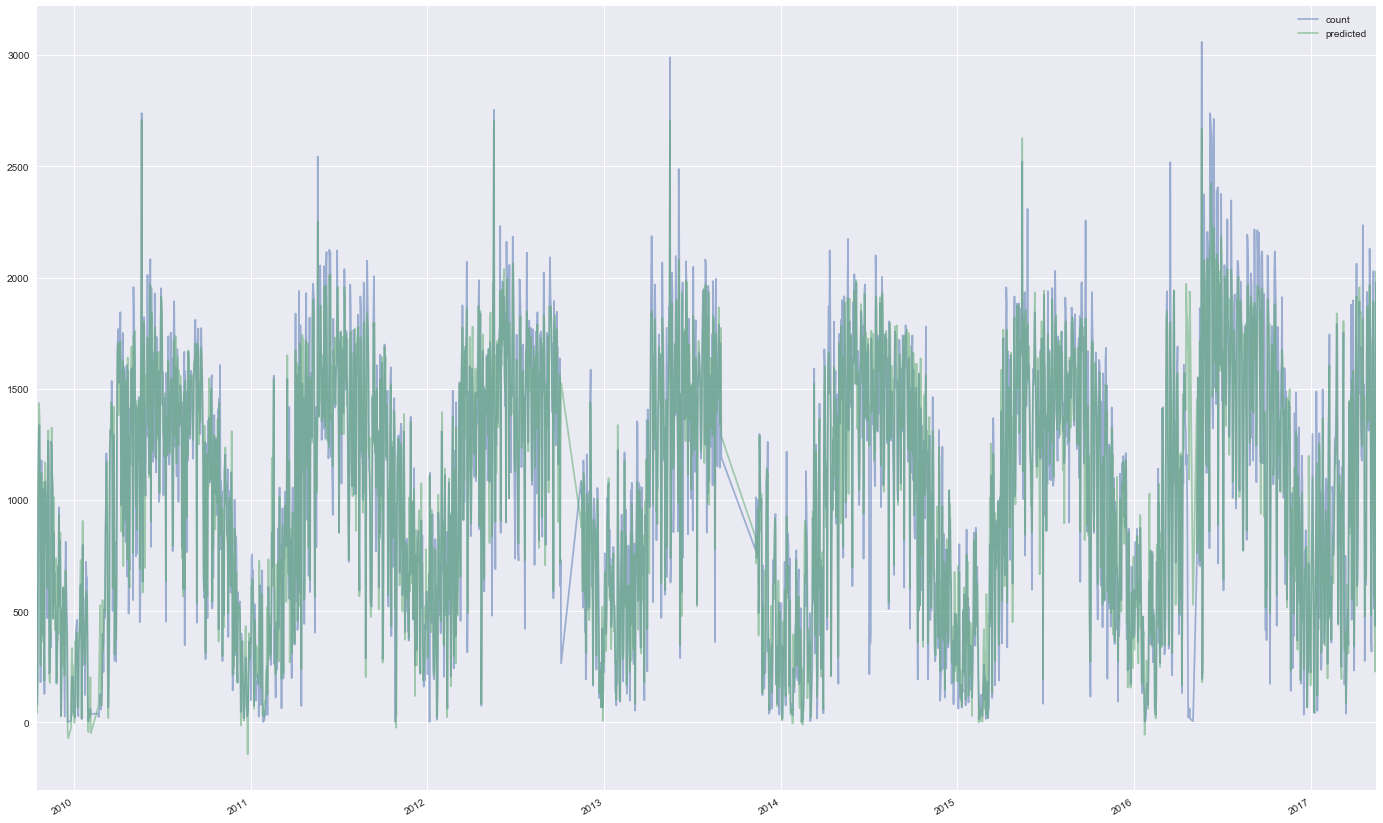

In [41]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns; sns.set()
bikedataframe['predicted'] = y_predit
bikedataframe[['count', 'predicted']].plot(figsize=(24,16),alpha=0.5)

Below you'll find a table that compares the actual count to predicted counts for the past 30 days.  Most days the predictions are pretty close. The only item that jumps out at me is for May 6th. The prediction (789) was much higher than the actual count (319). I wonder if there was some disruption on the trail that day.

In [42]:
bikedataframe[['count', 'predicted']].tail(30)

,count,predicted
2017-04-16,1177.0,1242.276148
2017-04-17,1263.0,1447.325830
2017-04-18,2236.0,1813.757141
2017-04-19,1449.0,1368.067171
2017-04-20,1521.0,1408.883854
2017-04-21,1257.0,1462.360464
2017-04-22,276.0,476.303339
2017-04-23,939.0,875.377852
2017-04-24,617.0,644.473440
2017-04-25,666.0,723.079040


Let me try to use this model to predict the daily bike counts for the Custis Rosslyn counter for the next few days. The weather forecast and other data for the next few days are listed below.

In [70]:
dfsunrise.loc['2017-05-17': '2017-05-20']

,month,day,year,sunrise,sunset,sunrise_int,sunset_int
2017-05-17,5,17,2017,5:54 a.m.,8:16 p.m.,554,2016
2017-05-18,5,18,2017,5:53 a.m.,8:17 p.m.,553,2017
2017-05-19,5,19,2017,5:52 a.m.,8:18 p.m.,552,2018
2017-05-20,5,20,2017,5:52 a.m.,8:19 p.m.,552,2019


In [72]:
forecast_data = {'date': ['2017-05-17', '2017-05-18', '2017-05-19', '2017-05-20'], 
                 'Max TemperatureF': [93.0, 92, 89, 70], 
                 'Min TemperatureF': [71.0, 71, 59, 55], 
                 'Max Humidity': [78.0, 64, 84, 71], 
                 'Max Wind SpeedMPH': [11.0, 12, 11, 10], 
                 'PrecipitationIn': [0.0, 0.0, 0.22, 0],
                 'weekday': [1, 1, 1, 0], 
                 'holiday': [0, 0, 0, 0], 
                 'day_hrs': [14.36, 14.39, 14.42, 14.45],
                 'snowtotal': [0, 0, 0, 0], 
                 'Fog': [0, 0, 0, 0], 
                 'year': [17.0, 17.0, 17.0, 17.0], 
                 'sunsethour': [20.267, 20.283, 20.3, 20.317], 
                 'CloudCover': [1, 3, 4, 3],
                 'bike_events': [0, 0, 1, 0]}

df_forecast = pd.DataFrame.from_dict(forecast_data)
df_forecast['date'] = pd.to_datetime(df_forecast.date)
df_forecast = df_forecast.set_index("date")


In [73]:
F = df_forecast[names]
y_forecast = exported_pipeline.predict(F)
y_forecast

array([ 1878.2631757 ,  1974.63097607,  2325.80212972,  1460.41111228])

In [74]:
print(int(y_forecast[0]), "bike counts forecast for May 17, 2017.")
print(int(y_forecast[1]), "bike counts forecast for May 18, 2017.")
print(int(y_forecast[2]), "bike counts forecast for May 19, 2017.")
print(int(y_forecast[3]), "bike counts forecast for May 20, 2017.")

1878 bike counts forecast for May 17, 2017.
1974 bike counts forecast for May 18, 2017.
2325 bike counts forecast for May 19, 2017.
1460 bike counts forecast for May 20, 2017.


I'll check back in the next few days and list the actual count data in the comments section below. 

As you could imagine, a model of daily bike usage could be useful for planning purposes. You could also use a tool like this to monitor data quality from the counter sensors by detecting large deviations from predicted counts. It also might alert government staff when external issues might be impacting bike trail usage.